In [1]:
import matplotlib.pyplot as plt  # This imports the matplotlib library, which is used for creating static, animated, and interactive visualizations in Python.
import torch  # This imports PyTorch, a popular open-source machine learning library for Python.
from torch.utils.data import DataLoader  # DataLoader is a PyTorch utility for loading and batching data.
from torchvision.datasets import MNIST  # This imports the MNIST dataset from torchvision, which is a popular dataset of handwritten digits.
from torchvision.transforms import ToTensor  # ToTensor is a transform that converts PIL Images or numpy.ndarrays to tensors.

from lcapt.analysis import make_feature_grid  # This imports a function from the lcapt library that creates a grid of features for visualization.
from lcapt.lca import LCAConv1D  # This imports the LCAConv1D class from the lcapt library. LCAConv1D is likely a type of convolutional layer based on Locally Competitive Algorithms (LCA).
from lcapt.metric import compute_l1_sparsity, compute_l2_error  # These are functions from the lcapt library that compute L1 sparsity and L2 error metrics, respectively.


In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.0.0+cu118
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: Quadro M2200


In [3]:
BATCH_SIZE = 64  # This sets the batch size for training the model. The batch size is the number of samples that will be passed through the model at once.
DEVICE = 0  # This might be specifying the device to run the model on. '1' usually refers to the second GPU, if available.
EPOCHS = 25  # This sets the number of epochs for training the model. An epoch is one complete pass through the entire dataset.
LAMBDA = 0.05  # This sets the threshold for Locally Competitive Algorithms (LCA) in lcapt.
LCA_ITERS = 800  # This sets the number of iterations for LCA.
LEARNING_RATE = 1e-2  # This sets the learning rate for training the model. The learning rate controls how much to update the model in response to the estimated error each time the model weights are updated.
OVERCOMPLETENESS = 2  # This might be specifying the overcompleteness of the representation in lcapt, which is often used in sparse coding.
PRINT_FREQ = 20  # This might be specifying how often to print out training logs.
TAU = 100 # This sets the time constant for LCA.


In [4]:
# This loads the MNIST dataset from torchvision, downloads it if necessary, and applies a transform to convert images to tensors.
dset = MNIST('./data', download=True, transform=ToTensor())  

# This creates a DataLoader for batching and shuffling data during training. It also specifies some settings for efficient data loading.
dataloader = DataLoader(
    dset, 
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True
)

In [8]:
torch.cuda.device_count()

1

In [9]:
print("device is ", DEVICE)

device is  0


In [10]:
lca = LCAConv1D(
    out_neurons=784 * OVERCOMPLETENESS,
    in_neurons=784,
    result_dir='./mnist_dictionary_learning',
    kernel_size=1,
    stride=1,
    lambda_=LAMBDA,
    tau=TAU,
    track_metrics=False,
    return_vars=['inputs', 'acts', 'recons', 'recon_errors'],
    pad='valid',
    eta=LEARNING_RATE
)
lca = lca.to(dtype=torch.float16, device=DEVICE)

In [11]:
for epoch in range(EPOCHS):
    if (epoch + 1) % 4 == 0:
        lca.lambda_ += 0.1

    for batch_num, (images, _) in enumerate(dataloader):
        images = images.reshape(images.shape[0], -1).unsqueeze(-1)
        images = images.to(dtype=torch.float16, device=DEVICE)
        inputs, code, recon, recon_error = lca(images)
        lca.update_weights(code, recon_error)
        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.lambda_).item()
            l2_recon_error = compute_l2_error(inputs, recon).item()
            total_energy = l2_recon_error + l1_sparsity
            print(f'Epoch: {epoch}; ',
                  f'Batch: {batch_num}; ',
                  f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
                  f'L1 Sparsity: {round(l1_sparsity, 2)}; ',
                  f'Total Energy: {round(total_energy, 2)}')
    torch.save(lca, 'lca_mnist.pt')

Epoch: 0;  Batch: 0;  L2 Recon Error: 60.25;  L1 Sparsity: 33.19;  Total Energy: 93.44
Epoch: 0;  Batch: 20;  L2 Recon Error: 5.85;  L1 Sparsity: 25.31;  Total Energy: 31.16
Epoch: 0;  Batch: 40;  L2 Recon Error: 4.81;  L1 Sparsity: 23.16;  Total Energy: 27.97
Epoch: 0;  Batch: 60;  L2 Recon Error: 4.15;  L1 Sparsity: 21.36;  Total Energy: 25.51
Epoch: 0;  Batch: 80;  L2 Recon Error: 4.15;  L1 Sparsity: 21.28;  Total Energy: 25.43
Epoch: 0;  Batch: 100;  L2 Recon Error: 3.65;  L1 Sparsity: 19.84;  Total Energy: 23.49
Epoch: 0;  Batch: 120;  L2 Recon Error: 3.61;  L1 Sparsity: 19.3;  Total Energy: 22.9
Epoch: 0;  Batch: 140;  L2 Recon Error: 3.58;  L1 Sparsity: 19.52;  Total Energy: 23.09
Epoch: 0;  Batch: 160;  L2 Recon Error: 3.6;  L1 Sparsity: 18.92;  Total Energy: 22.52
Epoch: 0;  Batch: 180;  L2 Recon Error: 3.36;  L1 Sparsity: 18.03;  Total Energy: 21.39
Epoch: 0;  Batch: 200;  L2 Recon Error: 3.28;  L1 Sparsity: 17.94;  Total Energy: 21.21
Epoch: 0;  Batch: 220;  L2 Recon Error: 

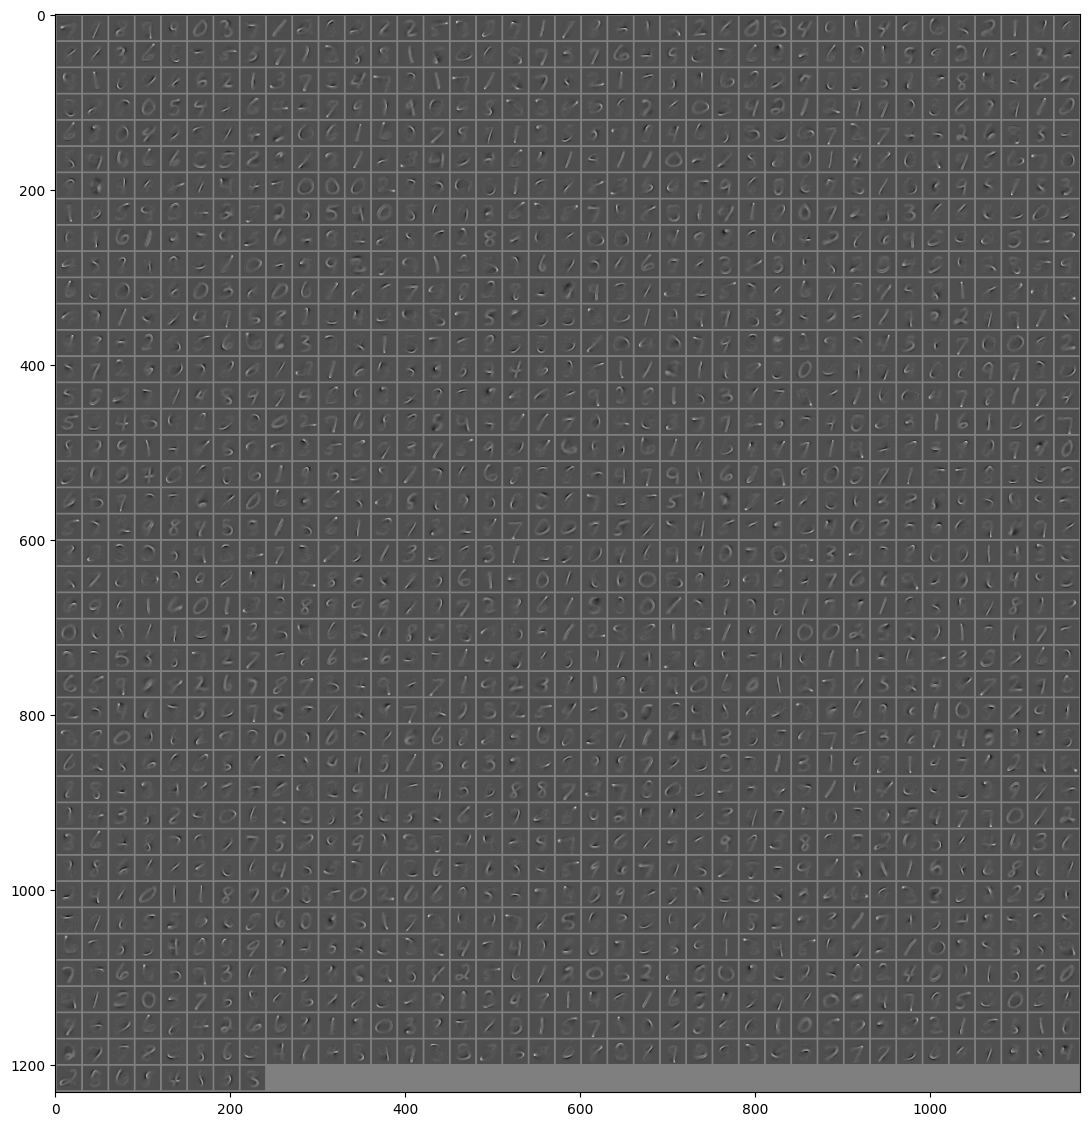

In [12]:
# reshapes the weights of the LCA model into a grid of feature maps
weight_grid = make_feature_grid(lca.get_weights().reshape(784 * OVERCOMPLETENESS, 1, 28, 28)) 
# creates a new figure and displays this grid of feature maps using imshow
fig = plt.figure(figsize=(14, 14))
plt.imshow(weight_grid.float().cpu().numpy())

Text(0.5, 1.0, 'Input - Reconstruction')

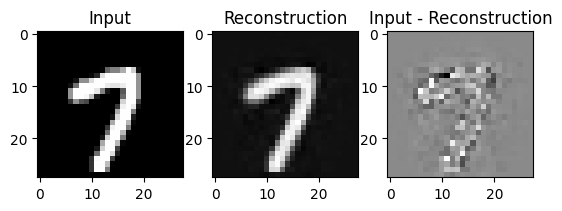

In [13]:
fig, ax = plt.subplots(1, 3)
inputs = inputs[0].float().cpu().numpy().reshape([28, 28])
recon = recon[0].float().cpu().numpy().reshape([28, 28])
recon_error = recon_error[0].float().cpu().numpy().reshape([28, 28])
recon = (recon - recon.min()) / (recon.max() - recon.min())
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
recon_error = (recon_error - recon_error.min()) / (recon_error.max() - recon_error.min())
img1 = ax[0].imshow(inputs, cmap='gray')
img2 = ax[1].imshow(recon, cmap='gray')
img3 = ax[2].imshow(recon_error, cmap='gray')
ax[0].set_title('Input')
ax[1].set_title('Reconstruction')
ax[2].set_title('Input - Reconstruction')